# Spam Detection - Classification


![image](https://storage.googleapis.com/kaggle-datasets-images/483/982/15b24a8964e8d4afadff79a1a5543450/dataset-cover.jpg)


This project aims to perform the SMS spam classification task using the [SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset).


## Project Navigation

- [1. Required Libraries](#1)
- [2. Checking the target variable](#2)
- [3. Data pre-processing](#3)
- [4. SMS Spam Classification](#4)
  - [4.1. Creating Sentence Embeddings](#4-1)
  - [4.2. Plotting the Embeddings](#4-2)
  - [4.3. Splitting Data: Train/Test](#4-3)
  - [4.4. Baseline](#4-4)
  - [4.5. Model Hyperparameter Tuning](#4-5)


<a id="1"></a>

## 1. Required Libraries


In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

import random
import numpy as np
import pandas as pd
import charset_normalizer
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, ClassifierMixin
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

np.random.seed(99)
random.seed(99)

# setting the number of parallel jobs when applicable
n_jobs = 15

In [2]:
# attempting to detect the csv file character encoding
with open("spam.csv", "rb") as csv:
    detected_encoding = charset_normalizer.detect(csv.read(250000))
    print(
        f"Detected encoding {detected_encoding['encoding']} with confidence level of {detected_encoding['confidence']}"
    )

df = pd.read_csv("spam.csv", encoding=detected_encoding["encoding"])
df = df.loc[:, ["v1", "v2"]]
df.info()


Detected encoding Windows-1252 with confidence level of 0.9988
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


<a id="2"></a>

## 2. Checking the target variable


Let's look into the target variable frequency distribution.


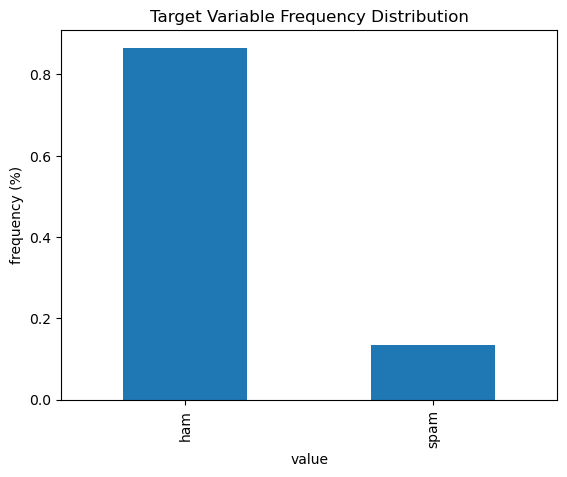

In [3]:
df["v1"].value_counts(normalize=True).plot(
    title="Target Variable Frequency Distribution",
    kind="bar",
    xlabel="value",
    ylabel="frequency (%)",
)
plt.show()


From the graph, we see that our data is highly unbalanced.


<a id="3"></a>

## 3. Data pre-processing


Let's encode the target variable values with 0s for hams and 1s for spams.

In [4]:
binarizer = LabelBinarizer()
df["target"] = binarizer.fit_transform(df["v1"].values)

<a id="4"></a>

## 4. SMS Spam Classification


For the SMS Spam Classification task, we will use some of the state-of-the-art sentence embeddings techniques.
Sentence embedding is a collection of techniques in natural language processing where sentences are mapped into an intermediate representation (vectors of real numbers).
The embeddings (vectors) are used as inputs for the machine learning and deep learning models.


<a id="4-1"></a>

### 4.1. Creating Sentence Embeddings


In [5]:
transformer = SentenceTransformer("all-mpnet-base-v2")
embeddings = transformer.encode(df["v2"], show_progress_bar=False)
print(embeddings.shape)


(5572, 768)


<a id="4-2"></a>

### 4.2. Plotting the Embeddings


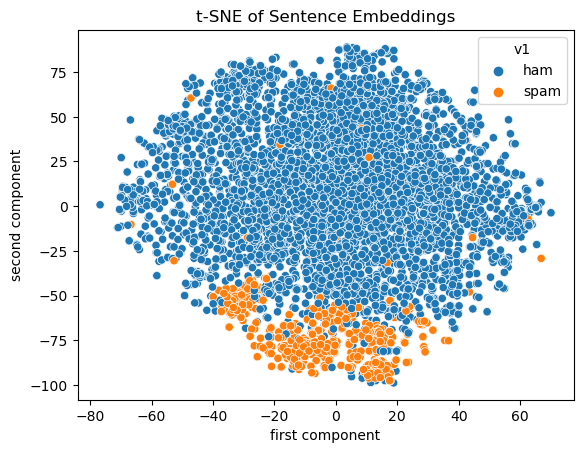

In [6]:
tsne = TSNE(random_state=99)
converted = tsne.fit_transform(embeddings)
plt.title("t-SNE of Sentence Embeddings")
sns.scatterplot(x=converted[:, 0], y=converted[:, 1], hue=df["v1"])
plt.xlabel("first component")
plt.ylabel("second component")
plt.show()


It seems that the sentence transformer did a great job creating the embeddings. We can see two clear clusters of data, for spams and hams.


<a id="4-3"></a>

### 4.3. Splitting Data: Train/Test


In [7]:
y = df["target"].values
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, y, test_size=0.25, shuffle=True, stratify=y, random_state=99
)
print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}")


X_train: (4179, 768)
X_test: (1393, 768)


<a id="4-4"></a>

### 4.4. Baseline


We will use a model based on support vector machines as our base model.


In [8]:
svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
auc = np.round(roc_auc_score(y_test, y_pred), 3)
print(f"Test ROC AUC: {auc}\n")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

Test ROC AUC: 0.968

Confusion Matrix:
[[1206    0]
 [  12  175]]


Here we are using the area under the ROC curve as the model evaluation metric. The ROC AUC metric is a better option in scenarios where the target variable is highly unbalanced, because it takes into account the true positive and false positive rates at the same time.

As we can see by the ROC AUC and confusion matrix metrics, our base model showed a pretty good performance. It misclassified 12 out of 1393 instances from the test set.

Now we will try to make its performance even better with hyperparameter tuning.


<a id="4-5"></a>

### 4.5. Model Hyperparameter Tuning


In [9]:
cv = GridSearchCV(
    estimator=SVC(kernel="rbf"),
    param_grid={
        "C": [0.1, 1, 10, 100, 1000],
        "gamma": [
            1,
            0.1,
            0.01,
            0.001,
            0.0001,
            1 / X_train.shape[1],
            1 / (X_train.shape[1] * X_train.var()),
        ],
        "kernel": ["rbf", "linear"],
    },
    n_jobs=n_jobs,
    scoring="roc_auc",
    cv=5,
)

cv.fit(X_train, y_train)
print(f"CV Best ROC AUC: {np.round(cv.best_score_, 3)}")
y_pred = cv.best_estimator_.predict(X_test)
auc = np.round(roc_auc_score(y_test, y_pred), 3)
print(f"Test ROC AUC: {auc}\n")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")
print(f"Best params:\n{cv.best_params_}")


CV Best ROC AUC: 0.998
Test ROC AUC: 0.971

Confusion Matrix:
[[1206    0]
 [  11  176]]

Best params:
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


We improved the performance of our model a little. The new model misclassified 11 out 1393 instances of the test set.

Now we have a SVC model with a fairly good performance, let's do the model deployment.

<a id="5"></a>
## 5. Model Deployment

To enable our model to support data in the same format as our dataset, we will extend the BaseEstimator class from sklearn and implement the necessary methods. With the implemented class, we will generate, fit and export a model that can be used by the most common ML Engines.

In [10]:
class SMSSpamDetector(BaseEstimator, ClassifierMixin):
    def __init__(self):
        super().__init__()
        self.model = SVC(kernel="rbf", C=10, gamma=1)
        self.label_binarizer = LabelBinarizer()
        self.sentence_transformer = SentenceTransformer("all-mpnet-base-v2")

    def fit(self, X, y):
        _X = self.sentence_transformer.encode(X.ravel()).reshape(X.shape[0], -1)
        _y = self.label_binarizer.fit_transform(y)
        self.model.fit(_X, _y)
        return self
    
    def predict(self, X):
        _X = self.sentence_transformer.encode(X.ravel()).reshape(X.shape[0], -1)
        return self.label_binarizer.inverse_transform(self.model.predict(_X))

# train the production model with the entire dataset
detector = SMSSpamDetector().fit(df["v2"].values, df["v1"].values)

# dump to model.joblib file
joblib.dump(detector, "model.joblib")

['model.joblib']